# Hypothesis Testing in Python

## Chapter 3: Proportion Tests

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, chisquare
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg
import matplotlib.pyplot as plt

In [33]:
late_shipments = pd.read_feather("late_shipments.feather")
late_shipments = late_shipments[late_shipments["vendor_inco_term"] != "DDU"].copy()
late_shipments

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,13608.0,Uganda,PMO - US,Direct Drop,DDP,Air,0.0,No,ARV,Adult,...,121.0,9075.00,75.00,0.62,"Janssen-Cilag, Latina, IT",Yes,43.0,199.00,reasonable,12.72
996,80394.0,"Congo, DRC",PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,292.0,9344.00,32.00,1.60,"Trinity Biotech, Plc",Yes,99.0,2162.55,reasonable,13.10
997,61675.0,Zambia,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2127.0,170160.00,80.00,0.80,"Alere Medical Co., Ltd.",Yes,881.0,14019.38,expensive,210.49
998,39182.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,191011.0,861459.61,4.51,0.15,"Aurobindo Unit III, India",Yes,16234.0,14439.17,expensive,1421.41


In [34]:
# Hypothesize that the proportion of late shipments is 6%
p_0 = 6/100

# Calculate the sample proportion of late shipments
p_hat = (late_shipments["late"]=="Yes").mean()

# Calculate the sample size
n = len(late_shipments["late"])

# Print p_hat and n
print(p_hat, n)

0.06106106106106106 999


In [35]:
# Calculate the numerator and denominator of the test statistic
numerator = p_hat - p_0
denominator = np.sqrt(p_0 * (1 - p_0) / n)

# Calculate the test statistic
z_score = numerator / denominator

# Print the result
print(z_score)

0.14121589054828845


In [36]:
# Calculate the p-value from the z-score
p_value = 1 - norm.cdf(z_score)

# Print the p-value
print(p_value)

0.44384969651518114


While bootstrapping can be used to estimate the standard error of any statistic, it is computationally intensive. For proportions, using a simple equation of the hypothesized proportion and sample size is easier to compute.

Here $p > \alpha$, so we reject the null hypothesis that proportion of shipments are late is greater than 6%.

$H_0$: $late_{\text{expensive}}$ - $late_{\text{reasonable}}$ $=0$
$H_1$: $late_{\text{expensive}}$ - $late_{\text{reasonable}}$ $>0$


In [37]:
p_hats = late_shipments.groupby("freight_cost_groups")["late"].value_counts(normalize=True)
p_hats

freight_cost_groups  late
expensive            No      0.920904
                     Yes     0.079096
reasonable           No      0.964758
                     Yes     0.035242
Name: proportion, dtype: float64

In [38]:
ns = late_shipments.groupby("freight_cost_groups")["late"].count()
ns

freight_cost_groups
expensive     531
reasonable    454
Name: late, dtype: int64

In [39]:
p_hat_expensive = p_hats[("expensive", "Yes")]
p_hat_reasonable = p_hats[("reasonable", "Yes")]
print(p_hat_expensive, p_hat_reasonable)

0.07909604519774012 0.03524229074889868


In [40]:
n_expensive = ns[("expensive")]
n_reasonable = ns[("reasonable")]
print(n_expensive, n_reasonable)

531 454


In [41]:
p_hat = (n_expensive * p_hat_expensive + n_reasonable * p_hat_reasonable)/(n_expensive + n_reasonable)

# Print the result
print(p_hat)

0.05888324873096447


In [42]:
# Calculate p_hat one minus p_hat
p_hat_times_not_p_hat = p_hat * ( 1 - p_hat)

# Divide this by each of the sample sizes and then sum
p_hat_times_not_p_hat_over_ns = p_hat_times_not_p_hat/n_expensive + p_hat_times_not_p_hat/n_reasonable

# Calculate the standard error
std_error = np.sqrt(p_hat_times_not_p_hat_over_ns)

# Print the result
print(std_error)

0.015047368671572671


In [43]:
# Calculate the z-score
z_score = (p_hat_expensive - p_hat_reasonable)/std_error

# Print z_score
print(z_score)

2.9143802751167707


In [44]:
# Calculate the p-value from the z-score
p_value = 1 - norm.cdf(z_score)

# Print p_value
print(p_value)

0.00178197741124142


This low p-value leads us to reject $H_0$ and suspect there is a larger proportion of late shipments for expensive freight compared to reasonable freight.

In [45]:
# Count the late column values for each freight_cost_group
late_by_freight_cost_group = late_shipments.groupby("freight_cost_groups")["late"].value_counts()

# Print the counts
print(late_by_freight_cost_group)

freight_cost_groups  late
expensive            No      489
                     Yes      42
reasonable           No      438
                     Yes      16
Name: count, dtype: int64


In [46]:
# Count the late column values for each freight_cost_group
late_by_freight_cost_group = late_shipments.groupby("freight_cost_groups")['late'].value_counts()

# Create an array of the "Yes" counts for each freight_cost_group
success_counts = np.array([late_by_freight_cost_group[("expensive", "Yes")], late_by_freight_cost_group[("reasonable", "Yes")]])

# Create an array of the total number of rows in each freight_cost_group
n = np.array([late_by_freight_cost_group[("expensive")].sum(), late_by_freight_cost_group[("reasonable")].sum()])

# Run a z-test on the two proportions
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative="larger")

# Print the results
print(stat, p_value)

2.9143802751167707 0.0017819774112414581


$H_0$: ```vendor_inco_term``` and ```freight_cost_group``` are independent.

$H_A$: ```vendor_inco_term``` and ```freight_cost_group``` are associated.

In [47]:
# Proportion of freight_cost_group grouped by vendor_inco_term
props = late_shipments.groupby("vendor_inco_term")["freight_cost_groups"].value_counts(normalize=True)

# Print props
print(props)

vendor_inco_term  freight_cost_groups
CIP               reasonable             0.680000
                  expensive              0.320000
DDP               expensive              0.550000
                  reasonable             0.450000
EXW               expensive              0.583448
                  reasonable             0.416552
FCA               reasonable             0.663636
                  expensive              0.336364
Name: proportion, dtype: float64


In [48]:
# Convert props to wide format
wide_props = props.unstack()

# Print wide_props
print(wide_props)

freight_cost_groups  expensive  reasonable
vendor_inco_term                          
CIP                   0.320000    0.680000
DDP                   0.550000    0.450000
EXW                   0.583448    0.416552
FCA                   0.336364    0.663636


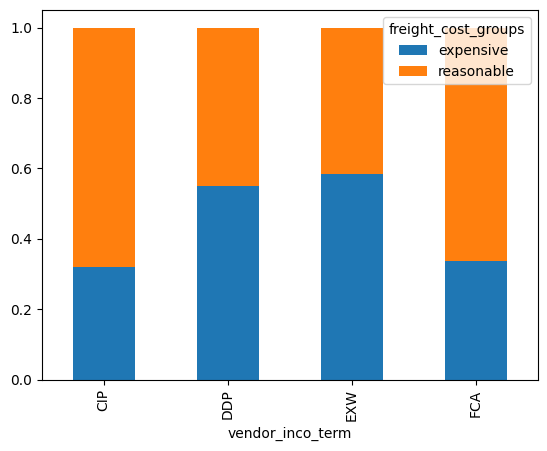

In [49]:
# Proportional stacked bar plot of freight_cost_group vs. vendor_inco_term
wide_props.plot(kind="bar", stacked=True)
plt.show()

In [52]:
# Determine if freight_cost_group and vendor_inco_term are independent
expected, observed, stats = pg.chi2_independence(data=late_shipments, x="freight_cost_groups", y="vendor_inco_term")

# Print results
print(stats[stats['test'] == 'pearson']) 

      test  lambda     chi2  dof          pval    cramer     power
0  pearson     1.0  33.6426  3.0  2.357026e-07  0.183511  0.999424


In [53]:
# Find the number of rows in late_shipments
n_total = late_shipments.shape[0]

# Print n_total
print(n_total)

999


In [54]:
# Create n column that is prop column * n_total
hypothesized["n"] = hypothesized["prop"] *n_total

# Print the modified hypothesized DataFrame
print(hypothesized)

  vendor_inco_term   prop        n
0              CIP  0.050   49.950
1              DDP  0.100   99.900
2              EXW  0.749  748.251
3              FCA  0.100   99.900


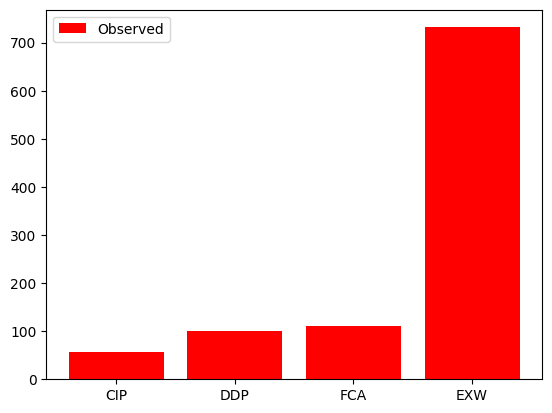

In [26]:
# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(incoterm_counts["vendor_inco_term"], incoterm_counts["n"], color="red", label="Observed")
plt.legend()
plt.show()

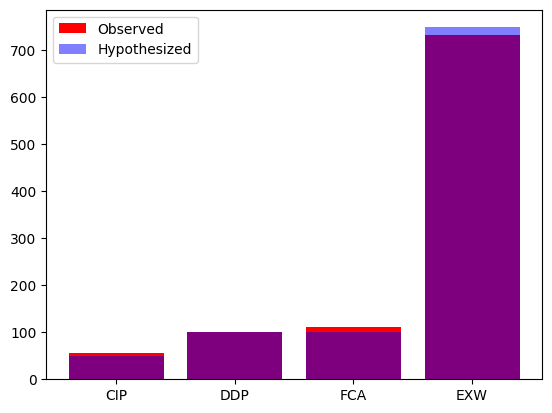

In [55]:
# Find the number of rows in late_shipments
n_total = len(late_shipments)

# Create n column that is prop column * n_total
hypothesized["n"] = hypothesized["prop"] * n_total

# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(incoterm_counts['vendor_inco_term'], incoterm_counts['n'], color="red", label="Observed")

# Add a blue bar plot for the hypothesized counts
plt.bar(hypothesized['vendor_inco_term'], hypothesized['n'], color="blue", alpha=0.5, label="Hypothesized")
plt.legend()
plt.show()

In [56]:
hypothesized = pd.DataFrame(
    zip(["CIP", "DDP", "EXW", "FCA"], [0.05, 0.10, 0.749, 0.10]),
    columns=["vendor_inco_term", "prop"]
)
hypothesized

,vendor_inco_term,prop
0,CIP,0.050
1,DDP,0.100
2,EXW,0.749
3,FCA,0.100


In [87]:
# Create n column that is prop column * n_total
hypothesized["n"] = hypothesized["prop"] * (n_total + 1)

# Print the modified hypothesized DataFrame
print(hypothesized)

  vendor_inco_term   prop      n
0              CIP  0.050   50.0
1              DDP  0.100  100.0
2              EXW  0.749  749.0
3              FCA  0.100  100.0


In [88]:
incoterm_counts = late_shipments["vendor_inco_term"].value_counts()
incoterm_counts = incoterm_counts.reset_index()
incoterm_counts.columns = ["vendor_inco_term", "n"]

incoterm_counts

,vendor_inco_term,n
0,EXW,732
1,FCA,111
2,DDP,100
3,CIP,56


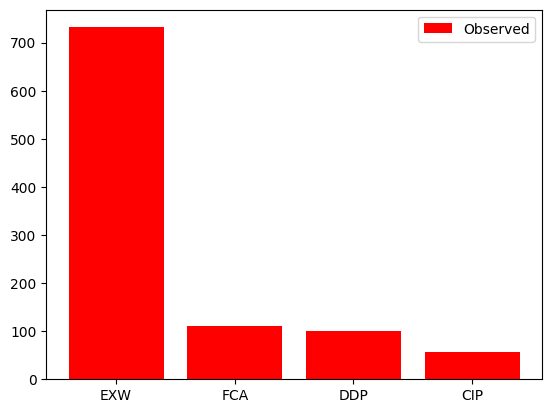

In [89]:
# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(incoterm_counts["vendor_inco_term"], incoterm_counts["n"], color="red", label="Observed")
plt.legend()
plt.show()

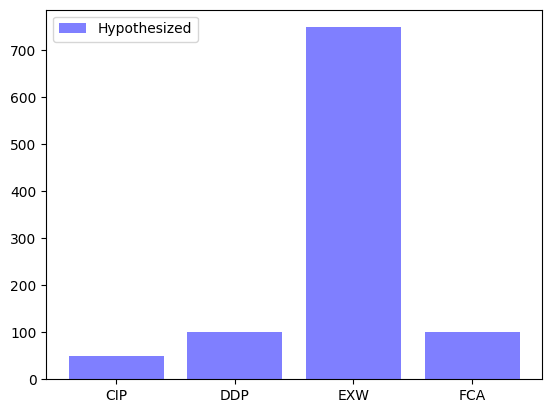

In [90]:
# Add a blue bar plot for the hypothesized counts
plt.bar(hypothesized['vendor_inco_term'], hypothesized['n'], color="blue", alpha=0.5, label="Hypothesized")
plt.legend()
plt.show()

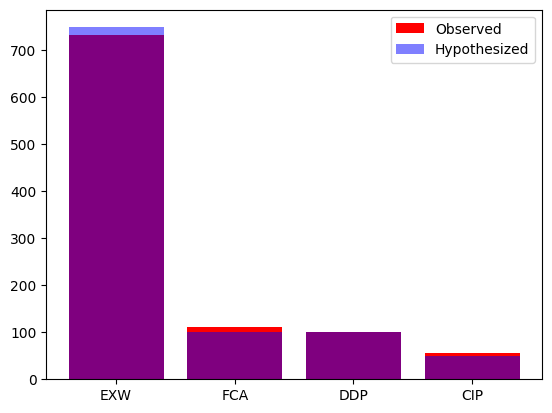

In [91]:
# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(incoterm_counts["vendor_inco_term"], incoterm_counts["n"], color="red", label="Observed")
plt.bar(hypothesized['vendor_inco_term'], hypothesized['n'], color="blue", alpha=0.5, label="Hypothesized")
plt.legend()

We need to keep the order of values same as ```chisquare``` function takes in series. So we will merge the two dataframes

In [96]:
df = pd.merge(
    incoterm_counts,
    hypothesized,
    how="inner",
    left_on="vendor_inco_term",
    right_on="vendor_inco_term",
)

df

,vendor_inco_term,n_x,prop,n_y
0,EXW,732,0.749,749.0
1,FCA,111,0.100,100.0
2,DDP,100,0.100,100.0
3,CIP,56,0.050,50.0


In [97]:
print(df["n_x"].sum())
print(df["n_y"].sum())


999
999.0


In [98]:
# Perform a goodness of fit test on the incoterm counts n
gof_test = chisquare(
    f_obs=df["n_x"],
    f_exp=df["n_y"]
)

# Print gof_test results
print(gof_test)

Power_divergenceResult(statistic=2.3158477970627502, pvalue=0.5094916902897231)


Since $p$ is greater than significance value of 0.1, we fail to reject the null hypothesis and conclude that ```n``` follows the distribution specified by ```hypothesized```